In [1]:
import pandas as pd
import numpy as np
import cv2
import pickle

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
import gc

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import tensorflow as tf

In [8]:
def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [9]:
queue = load_file('/home/ormenesse/Documents/Reinforced_Outrun/Analyse_Data/fila_primeiro_treino.pkl')

In [10]:
len(queue)

3587

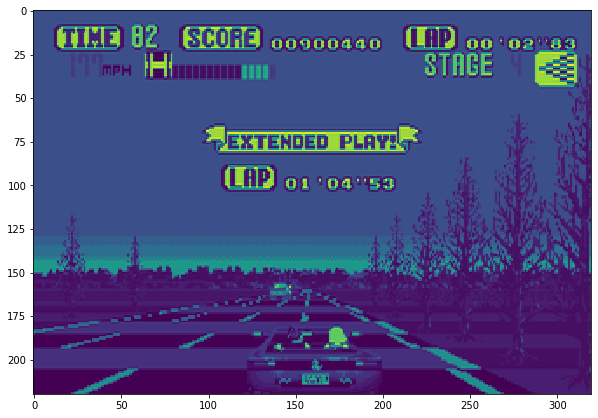

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(queue[2000][0])

In [12]:
queue[2000][1]

[1, 0, 0, 0, 0]

In [13]:
def capture_return_images(images): 
    
    # predict command
    imgs = np.array(images).astype(np.uint8)
    #imgs = np.expand_dims(imgs, axis=0)
    imgs = np.swapaxes(imgs,0,1)
    imgs = np.swapaxes(imgs,1,2)
    
    return imgs

#### Creating DataFrame

In [14]:
cmds = []
frame_imgs = []

In [15]:
%%time
for i in np.arange(5,len(queue),1):
    frame_imgs.append(capture_return_images([j[0] for j in queue[i-5:i]]))
    cmds.append(queue[i][1])

CPU times: user 475 ms, sys: 463 ms, total: 938 ms
Wall time: 553 ms


In [16]:
frame_imgs = np.array(frame_imgs)

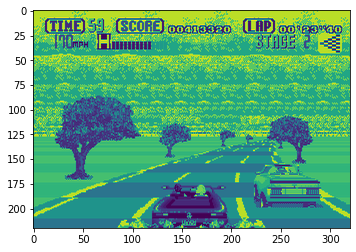

In [17]:
plt.imshow(frame_imgs[350,:,:,0])

Arrumando Comandos


In [18]:
com =      [10000*i[0] +  1000*i[1]    +100*i[2]  +10*i[3]     +1*i[4]    for i in cmds]

In [19]:
com = pd.get_dummies(com)

In [20]:
com.describe()

,0,10,11,100,101,1000,1010,1100,10000,10001,10010,10011,10100,10101
count,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000
mean,0.012004,0.056951,0.000279,0.045505,0.000279,0.001117,0.011725,0.013959,0.481854,0.006421,0.193747,0.002513,0.173367,0.000279
std,0.108920,0.231782,0.016708,0.208439,0.016708,0.033403,0.107662,0.117336,0.499740,0.079885,0.395288,0.050069,0.378617,0.016708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
com.shape, len(frame_imgs)

((3582, 14), 3582)

In [22]:
#input_shape = (img_rows, img_cols, 1)
input_shape = (220, 320, 5)
num_classes = com.shape[1]
batch_size = 32
epochs = 60 #600

In [23]:
# CRIANDO MODELO

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: x/255,input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
#model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.add(tf.keras.layers.Dense(num_classes))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 220, 320, 5)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 108, 158, 128)     16128     
_________________________________________________________________
batch_normalization (BatchNo (None, 108, 158, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 108, 158, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 158, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 79, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 38, 128)       4

In [25]:
# train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(range(0,com.shape[0]),range(0,com.shape[0]), test_size=0.1, random_state=42)

In [26]:
#model.compile(loss=keras.losses.binary_crossentropy,
#              optimizer=keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs),
#              metrics=['accuracy'])
INIT_LR = 1e-3
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer='adam',
              metrics=['acc'])

In [ ]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('modelo_outrun_encoded_learning_best_mse.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(frame_imgs[X_train,:,:,:], com.iloc[X_train].values,
          batch_size=batch_size,
          epochs=epochs,
          shuffle = True,
          validation_data=(frame_imgs[X_test,:,:,:], com.iloc[X_test].values),
          callbacks=[mcp_save, earlyStopping])
score = model.evaluate(frame_imgs[X_test,:,:,:], com.iloc[X_test].values, verbose=0)
print('Test loss:', score[0])

Train on 3223 samples, validate on 359 samples
Epoch 1/60
3223/3223 [==============================] - 220s 68ms/sample - loss: 2.1222 - acc: 0.3056 - val_loss: 0.0661 - val_acc: 0.4596
Epoch 2/60
3223/3223 [==============================] - 217s 67ms/sample - loss: 0.2183 - acc: 0.4480 - val_loss: 0.0607 - val_acc: 0.4596
Epoch 3/60
3223/3223 [==============================] - 214s 67ms/sample - loss: 0.1002 - acc: 0.4626 - val_loss: 0.0567 - val_acc: 0.4596
Epoch 4/60
3223/3223 [==============================] - 216s 67ms/sample - loss: 0.0707 - acc: 0.4735 - val_loss: 0.0540 - val_acc: 0.4596
Epoch 5/60
3223/3223 [==============================] - 215s 67ms/sample - loss: 0.0641 - acc: 0.4778 - val_loss: 0.0523 - val_acc: 0.4596
Epoch 6/60
3223/3223 [==============================] - 230s 71ms/sample - loss: 0.0643 - acc: 0.4753 - val_loss: 0.0514 - val_acc: 0.4596
Epoch 7/60
3223/3223 [==============================] - 238s 74ms/sample - loss: 0.0555 - acc: 0.4794 - val_loss: 0.050

In [ ]:
model.save_weights("model_3_encoded_learning_final_mse.hdf5")
model.save("model_3_encoded_learning_mse.model")